# Previsão de Votação de Deputados

### Sobre a tarefa

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

1. Baixe os dados [aqui](https://canvas.instructure.com/courses/1389733/files/69523670/download?verifier=A5EPvssqIQCjlxpWQyesLFer1VDTlRyTAAXR2iyi&wrap=1) (veja descrição dos dados mais abaixo).
2. Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para construir seus modelos de regressão. Isso implica, dentre outras coisas:
    - Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.   
    - Construir modelos de regressão com (ridge e lasso) e sem regularização.    
    - Considerar também modelos de regressão não paramétrica como K-NN.    
    - Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests).    
    - Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados.    
    - Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.    
3. Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.
    - Dica: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados.    
4. Responder:
    - Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.
    
A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

### Sobre os dados

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do [TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/index.html), pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

|  Variável  | Tipo | Descrição |
|:------------|:------:|:-----------|
|"sequencial_candidato" | (character) | id do candidato|
|"nome"| (character) | |
|"uf" | (character) | |
|"partido" | (character)| |
|"quantidade_doacoes"| (integer)| |
|"quantidade_doadores"| (integer) | número de doadores diferentes|
|"total_receita" | (double) | soma em R\$ das doações |
|"media_receita" | (double) | média das doações |
|"recursos_de_outros_candidatos/comites" | (double) | quantia em R\$ das doações provenientes de outros candidatos ou comite partidário |
|"recursos_de_pessoas_fisicas" | (double) | quantia em R\$ das doações provenientes de outros CPFs |
|"recursos_de_pessoas_juridicas" | (double) | quantia em R\$ das doações provenientes de outros CNPJ |
|"recursos_proprios" | (double) | quantia em R\$ das doações provenientes do próprio candidato |
|"recursos_de_partido_politico" | (double) | quantia em R\$ das doações provenientes do partido político do candidato |
|**"votos"** | (integer) | **variável alvo**. Se refere ao número de votos na campanha de 2006 e 2010 |
|"quantidade_despesas" | (integer) | |
|"quantidade_fornecedores" | (integer) | número de fornecedores/despesas diferentes |
|"total_despesa" | (double) | soma em R$ das despesas de campanha |
|"media_despesa" | (double) | média das despesas de campanha |
|"cargo" |(character) | |
|"Sexo": | (character) | |
|"grau": | (character) | grau de instrução do candidato |
|"estado_civil" | (character) |
|"ocupacao" | (character) | ocupação do candidato |

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
# Carregando o dataset eleições
eleicoes2006a2010 = pd.read_csv('eleicoes_2006_a_2010.csv')

In [4]:
# Visualizando as colunas do dataset
eleicoes2006a2010.columns

Index(['ano', 'sequencial_candidato', 'nome', 'uf', 'partido',
       'quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos'],
      dtype='object')

In [5]:
# Separando os datasets para treino e teste
# Treino
eleicoes2006 = eleicoes2006a2010[eleicoes2006a2010['ano'] == 2006]
# Selecionando os atributos a serem utilizados no treino
train = eleicoes2006.loc[:,['sequencial_candidato', 'uf', 'partido',
       'quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos']]
# Teste
eleicoes2010 = eleicoes2006a2010[eleicoes2006a2010['ano'] == 2010]
# Selecionando os atributos a serem utilizados no teste
test = eleicoes2010.loc[:,['sequencial_candidato','uf','partido',
       'quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos']]

In [6]:
train.head()

,sequencial_candidato,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,10001,AP,PT,6,6,16600.00,2766.666667,NaN,9000.0,6300.00,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,10002,RO,PT,13,13,22826.00,1755.846154,6625.0,15000.0,1000.00,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,10002,AP,PT,17,16,148120.80,9257.550000,2250.0,34150.0,62220.80,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,10002,MS,PRONA,6,6,3001.12,500.186667,NaN,1150.0,1101.12,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,10003,RO,PT,48,48,NaN,NaN,NaN,50878.0,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


In [7]:
# Concatenando os preditores dos datasets de treino e teste
all_data = pd.concat((train.loc[:,'uf':'ocupacao'],
                      test.loc[:,'uf':'ocupacao']))

In [8]:
all_data.head()

,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao
0,AP,PT,6,6,16600.00,2766.666667,NaN,9000.0,6300.00,1300.0,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR
1,RO,PT,13,13,22826.00,1755.846154,6625.0,15000.0,1000.00,201.0,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL
2,AP,PT,17,16,148120.80,9257.550000,2250.0,34150.0,62220.80,59500.0,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO
3,MS,PRONA,6,6,3001.12,500.186667,NaN,1150.0,1101.12,750.0,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO
4,RO,PT,48,48,NaN,NaN,NaN,50878.0,NaN,68942.0,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO


## Pré-processamento dos dados

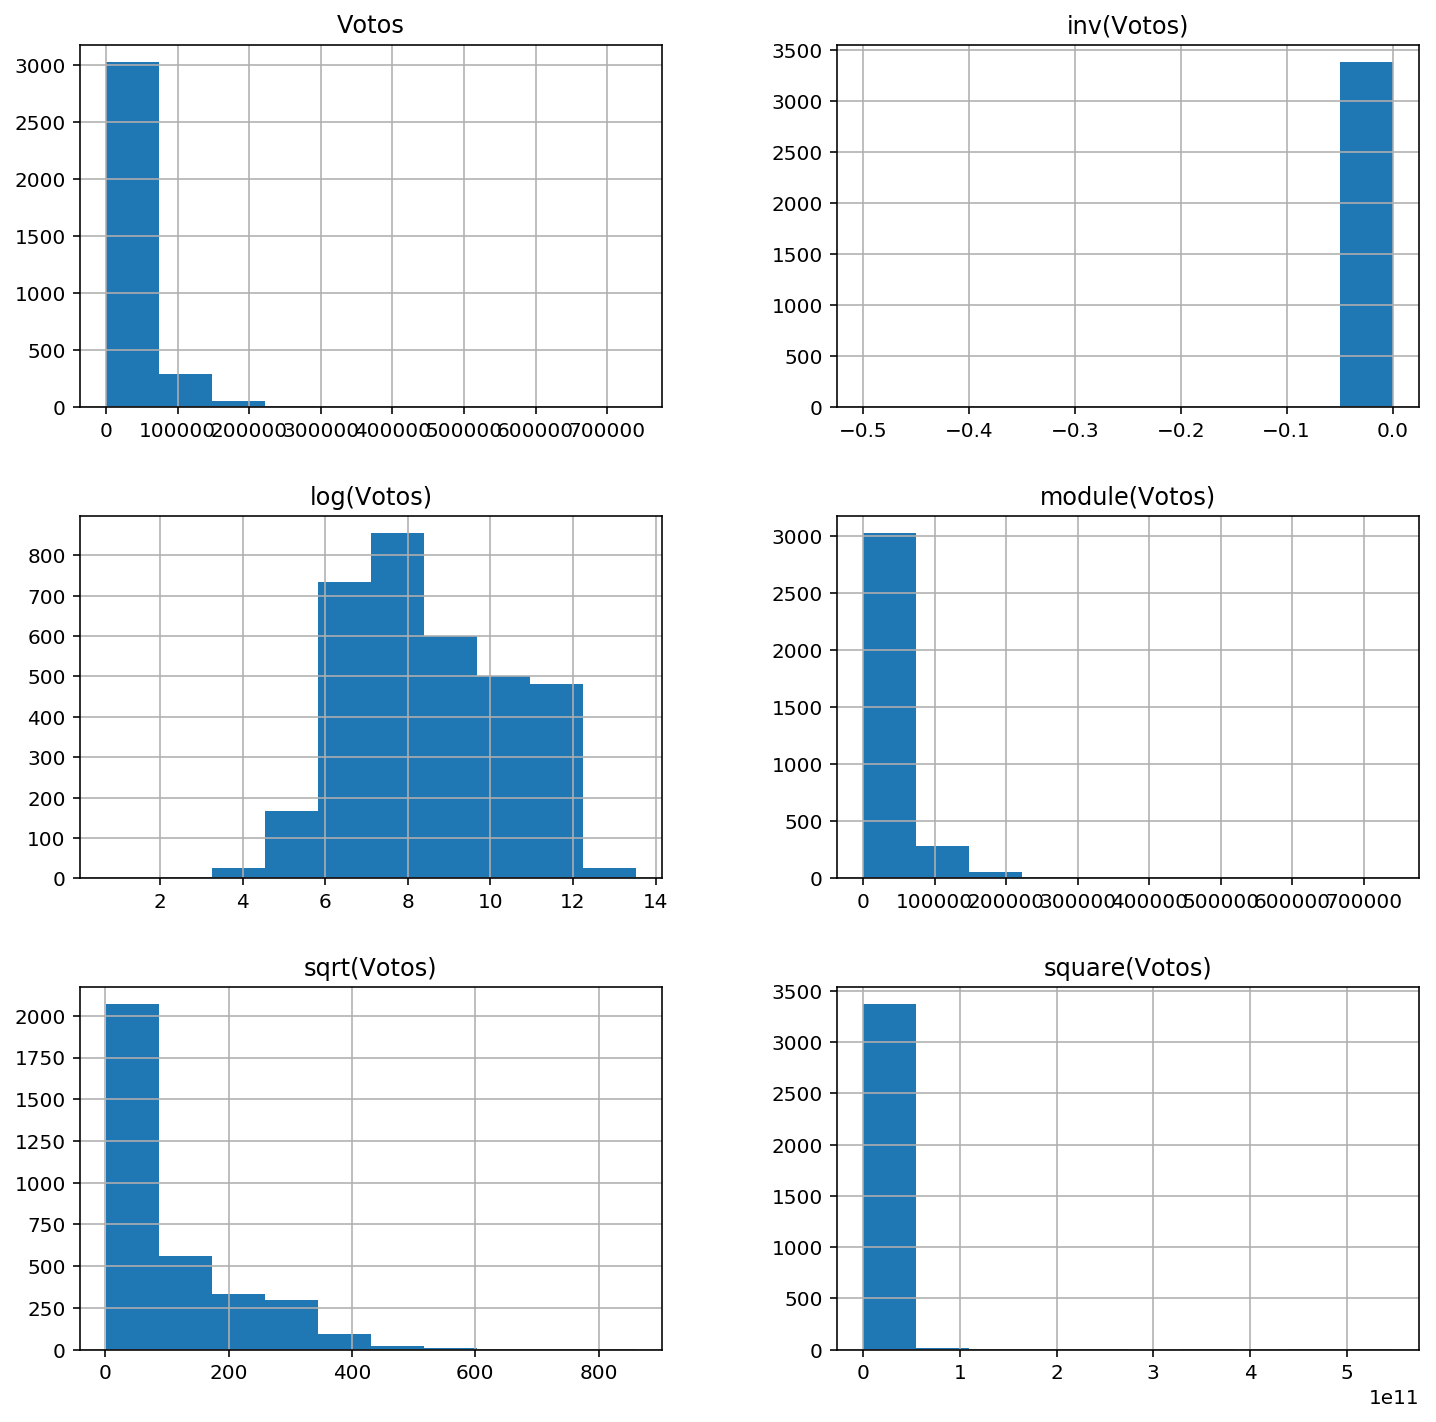

In [9]:
# Verificando quais transformação normaliza os dados
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
votos = pd.DataFrame({"Votos":train["votos"], "log(Votos)":np.log(train["votos"]), \
                       "sqrt(Votos)":np.sqrt(train["votos"]),"square(Votos)":np.square(train["votos"]), \
                     "module(Votos)":np.abs(train["votos"]), "inv(Votos)":(-1/train["votos"])})
votos.hist()
plt.show()

A maioria dos algoritmos de aprendizado de máquina funciona melhor se os recursos tiverem uma distribuição normal. 

In [10]:
#log transform the target:
train["votos"] = np.log1p(train["votos"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [11]:
all_data = pd.get_dummies(all_data)

In [12]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [13]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.votos

In [14]:
X_train.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,...,"ocupacao_TÉCNICO DE OBRAS CIVIS, ESTRADAS, SANEAMENTO E ASSEMELHADOS",ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,1.945910,1.945910,9.717218,7.925760,8.324939,9.105091,8.748464,7.170888,2.708050,2.708050,...,0,0,0,0,0,0,1,0,0,0
1,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,3.218876,3.178054,...,0,0,0,0,0,0,0,0,0,0
2,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,4.820282,4.691348,...,0,0,0,0,0,0,0,0,0,0
3,1.945910,1.945910,8.007074,6.216979,8.324939,7.048386,7.004991,6.621406,2.197225,2.197225,...,0,0,0,0,0,0,0,0,0,0
4,3.891820,3.891820,9.634619,7.466020,8.324939,10.837206,10.011960,11.141035,4.897840,4.795791,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X_test.head()

,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,...,"ocupacao_TÉCNICO DE OBRAS CIVIS, ESTRADAS, SANEAMENTO E ASSEMELHADOS",ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
3388,3.610918,3.583519,12.916305,9.361041,12.503138,10.975944,8.926358,11.463068,4.007333,3.891820,...,0,0,0,0,0,0,0,0,0,0
3389,1.386294,1.386294,8.852379,7.754053,8.324939,8.984406,8.610866,7.313887,1.386294,1.386294,...,0,0,0,0,0,0,0,0,0,0
3390,1.386294,1.386294,7.518064,6.420538,5.673323,7.313887,10.011960,3.931826,1.386294,1.386294,...,0,0,0,0,0,0,0,0,0,0
3391,0.693147,0.693147,6.089045,6.089045,6.089045,8.984406,10.011960,8.431020,0.693147,0.693147,...,0,0,0,0,0,0,0,0,0,0
3392,2.772589,2.639057,12.394629,9.829729,8.324939,8.716208,11.100451,9.296610,4.430817,4.094345,...,0,0,0,0,0,0,0,0,0,0


### Modelos

Agora vamos usar modelos de regressão lineares utilizando o módulo de aprendizado do scikit.

#### Regressão linear sem regularização

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
lm = LinearRegression()

In [18]:
lm.fit(X_train,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
# Printando a intercepção
print(lm.intercept_)

18905221901.87302


In [20]:
# Coeficente da regressão sem regularização
coef_df = pd.DataFrame(lm.coef_,X_train.columns,columns=['Coefficient'])
coef_df.head(10)

,Coefficient
quantidade_doacoes,-0.296077
quantidade_doadores,0.661785
total_receita,0.047585
media_receita,0.131120
recursos_de_outros_candidatos/comites,0.048504
recursos_de_pessoas_fisicas,0.030387
recursos_de_pessoas_juridicas,0.029640
recursos_proprios,-0.006116
quantidade_despesas,0.077707
quantidade_fornecedores,1.120890


In [21]:
from sklearn import metrics
#print('MAE:', metrics.mean_absolute_error(y, predictions))
#print('MSE:', metrics.mean_squared_error(y, predictions))
#print('RMSE:', np.sqrt(metrics.mean_squared_error(y, predictions)))

#### Regressão linear com regularização

In [22]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

#### Regressão linear com regularização Ridge

In [23]:
model_ridge = Ridge()

In [24]:
model_ridge.fit(X_train,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [25]:
# Printando a intercepção
print(model_ridge.intercept_)

1.6371261652898816


In [26]:
# Coeficente da regressão com regularização ridge
coef_ridge = pd.DataFrame(model_ridge.coef_,X_train.columns,columns=['Coefficient'])
coef_ridge.head(10)

,Coefficient
quantidade_doacoes,-0.275906
quantidade_doadores,0.646945
total_receita,0.043865
media_receita,0.134765
recursos_de_outros_candidatos/comites,0.049364
recursos_de_pessoas_fisicas,0.031614
recursos_de_pessoas_juridicas,0.031818
recursos_proprios,-0.005446
quantidade_despesas,0.067061
quantidade_fornecedores,1.049819


O principal parâmetro de ajuste para o modelo Ridge é alpha - um parâmetro de regularização que mede quão flexível é nosso modelo. Quanto maior a regularização, menos propenso será o nosso modelo de overfit. No entanto, também perderá a flexibilidade e poderá não capturar todo o sinal nos dados.

In [27]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

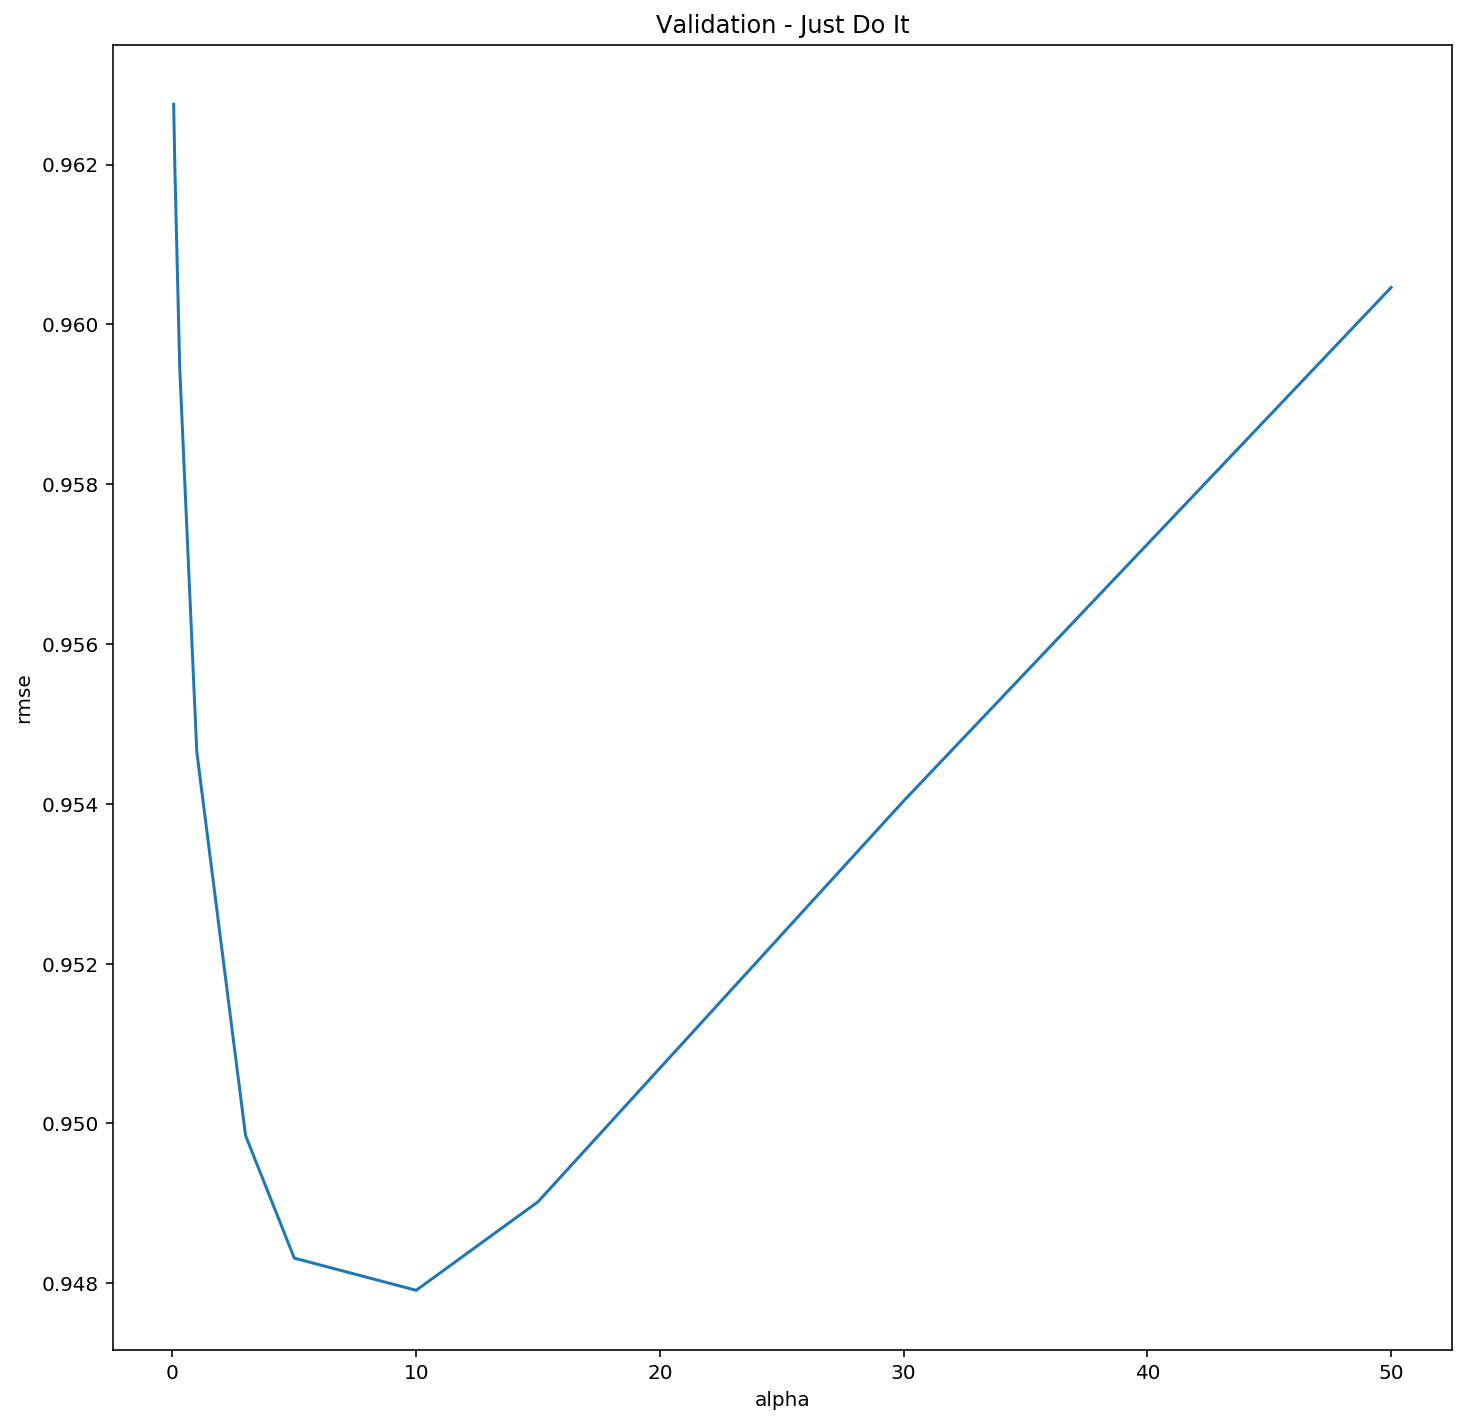

In [28]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [29]:
cv_ridge.min()

0.9479115249847114

In [30]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=10000).fit(X_train, y)

In [31]:
rmse_cv(model_lasso).mean()

0.9501097590701928

In [32]:
# Printando a intercepção
print(model_lasso.intercept_)

1.8004518439331516


In [33]:
# Coeficientes da regressão com regularização lasso
coef_lasso = pd.DataFrame(model_lasso.coef_, index = X_train.columns, columns=['Coefficient'])
coef_lasso.head(10)

,Coefficient
quantidade_doacoes,-0.110261
quantidade_doadores,0.501697
total_receita,0.034032
media_receita,0.143505
recursos_de_outros_candidatos/comites,0.049294
recursos_de_pessoas_fisicas,0.035483
recursos_de_pessoas_juridicas,0.038919
recursos_proprios,-0.003388
quantidade_despesas,0.000000
quantidade_fornecedores,0.824905


In [38]:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

In [39]:
print("O Lasso selecionou " + str(sum(coef_lasso != 0)) + " variaveis e eliminou outras " +  str(sum(coef_lasso == 0)) + " variables")

O Lasso selecionou 103 variaveis e eliminou outras 157 variables


In [40]:
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10),
                     coef_lasso.sort_values().tail(10)])

Podemos perceber pela visualização acima que o atributo mais importante é `quantidade_fornecedores` seguido da `media_despesa` e ter a ocupação deputado.

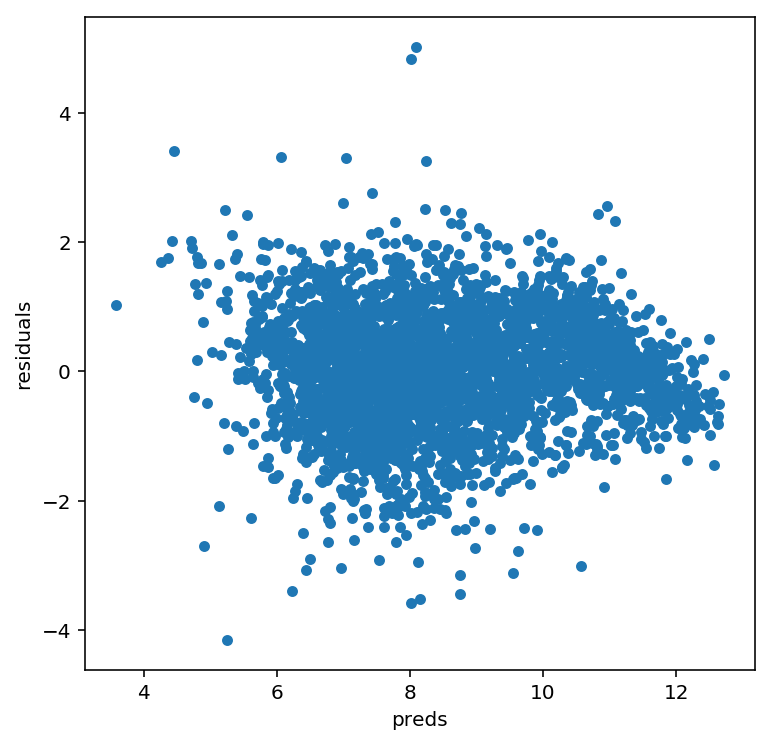

In [42]:
#Vendo os resíduos
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.show()